### (1) Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### (2) Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
                nn.Tanh(),
            )
        
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

### (3) Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer=True),
        )
        
    def disc_block(self, in_, out, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_, out, kernel_size, stride),
                nn.BatchNorm2d(out),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_, out, kernel_size, stride)
            )
        
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### (4) Noise 생성

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### (5) Class 처리


### (5-1) one-hot vector 생성

In [ ]:
import torch.nn.functional as F
def get_one_Hot_labels(labels, n_clases):
  return F.one_hot(labels, n_classes)

### (5-2) latent vector와 one-hot vector의 concatenation

In [ ]:
def combine_vectors(x, y):
  combined = torch.cat((x.float(), y.float()), 1)
  return combined

### (6) 기타

### (6-1) 파라미터 세팅

In [ ]:
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cpu'
criterion = nn.BCEWithLogitsLoss()
mnist_shape = (1, 28, 28)
n_classes = 10

### (6-2) 데이터 로드

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])


dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### (6-3) optimizer

In [ ]:
def get_input_dimensions(zdim, mnist_shape, n_classes):
  generator_input_dim = z_dim + n_classes
  discriminator_im_chan = mnist_shape[0] + n_classes
  return generator_input_dim, discriminator_im_chan

In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(z_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### (6-4) image display

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28), nrow=5, show=True):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  if show:
    plt.show()

### (7) training

step 500: Generator loss: 0.9833859111070633, discriminator loss: 0.5009787380099296


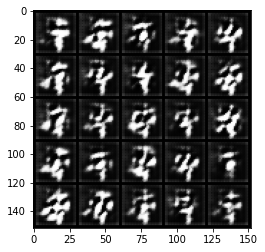

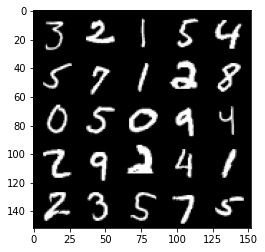

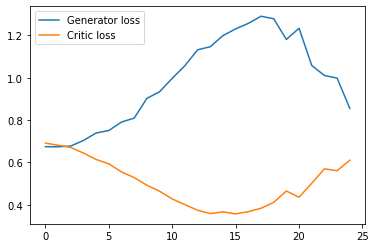

step 1000: Generator loss: 0.7704259032011032, discriminator loss: 0.674636041879654


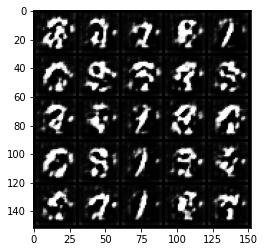

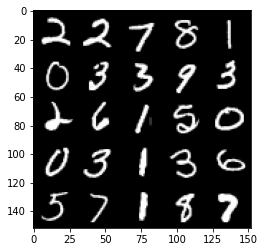

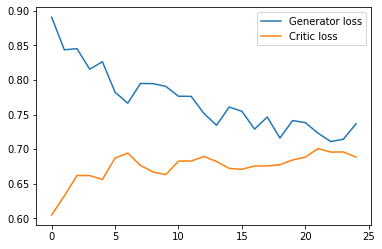

step 1500: Generator loss: 0.7252758021354675, discriminator loss: 0.693058073759079


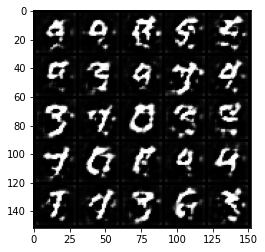

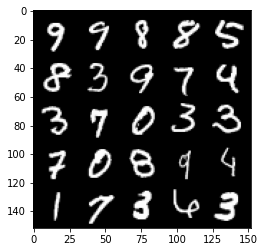

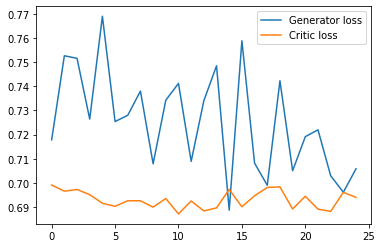

step 2000: Generator loss: 0.7089933631420136, discriminator loss: 0.6950533213615417


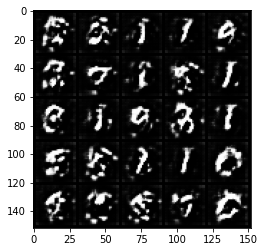

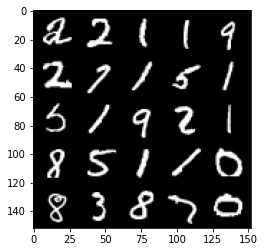

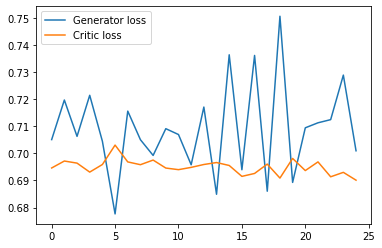

step 2500: Generator loss: 0.7071548651456833, discriminator loss: 0.6928514647483826


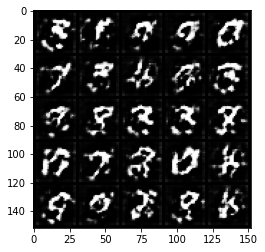

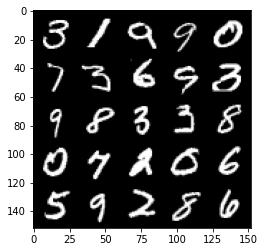

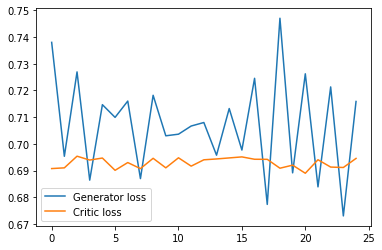

step 3000: Generator loss: 0.7042683320045471, discriminator loss: 0.6923179675340653


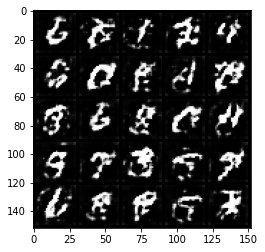

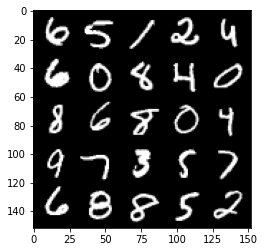

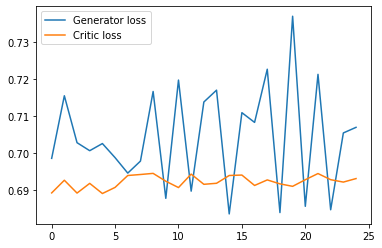

step 3500: Generator loss: 0.6964555816650391, discriminator loss: 0.6941535875797272


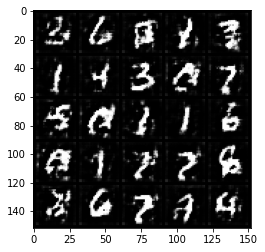

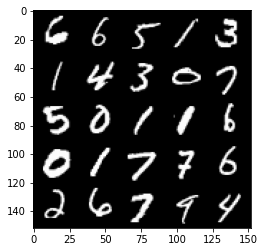

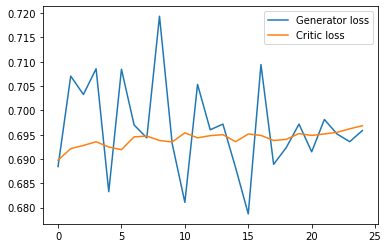

step 4000: Generator loss: 0.6970056699514389, discriminator loss: 0.6956851731538772


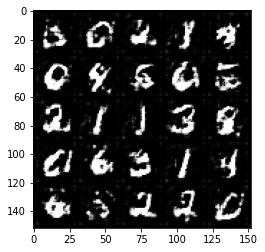

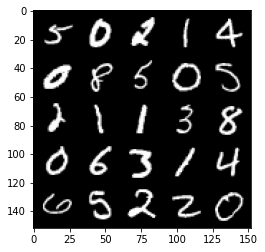

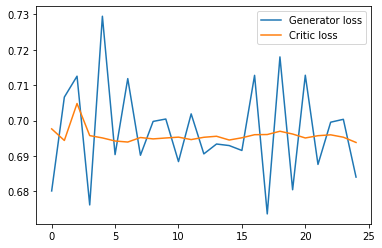

step 4500: Generator loss: 0.6962264350652695, discriminator loss: 0.6954527546167374


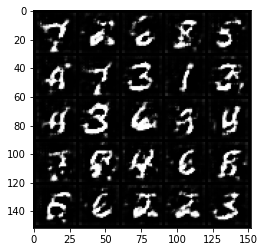

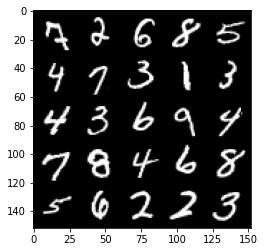

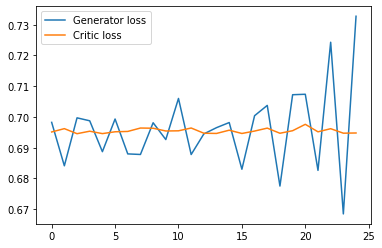

step 5000: Generator loss: 0.6935189448595047, discriminator loss: 0.6953976818323135


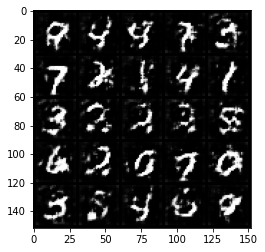

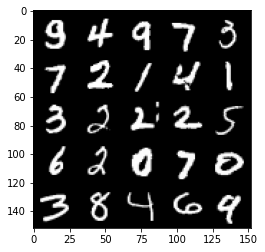

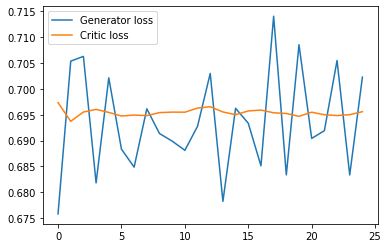

step 5500: Generator loss: 0.6930671116113662, discriminator loss: 0.6951903676986695


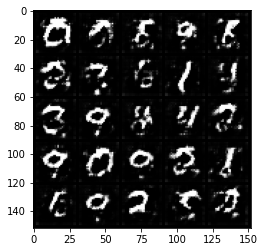

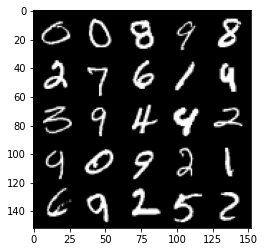

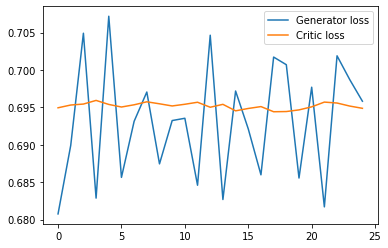

step 6000: Generator loss: 0.695208552479744, discriminator loss: 0.6945836147069931


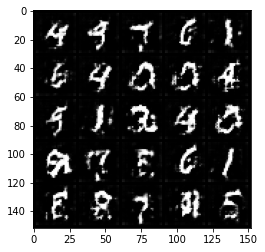

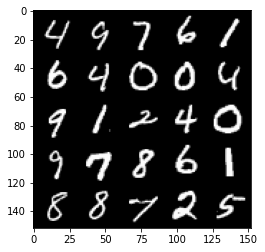

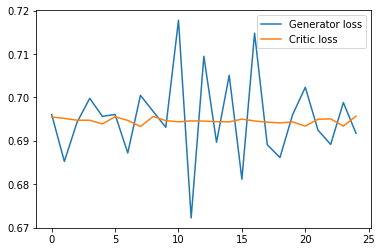

step 6500: Generator loss: 0.69437473154068, discriminator loss: 0.6945114412307739


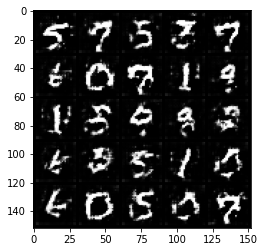

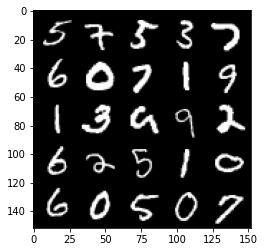

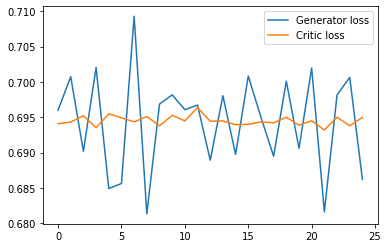

step 7000: Generator loss: 0.6950683143138886, discriminator loss: 0.6942842180728912


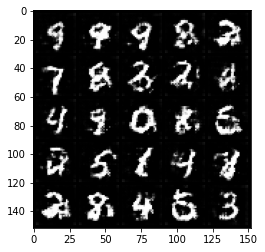

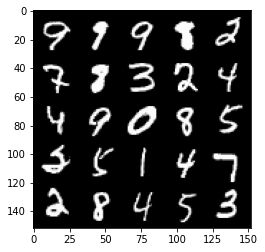

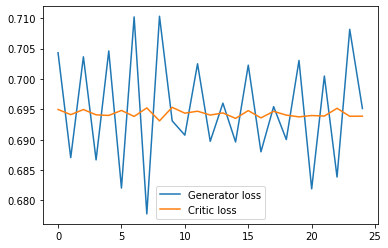

step 7500: Generator loss: 0.6942446904182434, discriminator loss: 0.6941565371751786


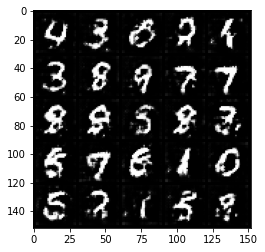

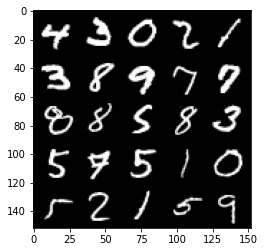

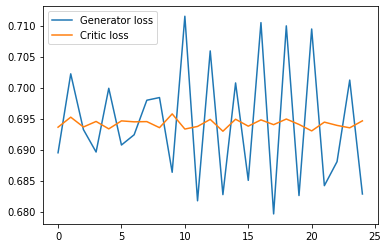

step 8000: Generator loss: 0.694567263841629, discriminator loss: 0.6940165009498597


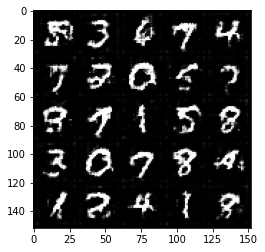

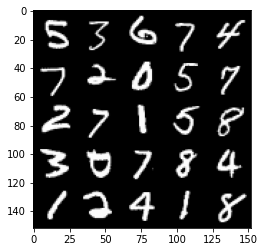

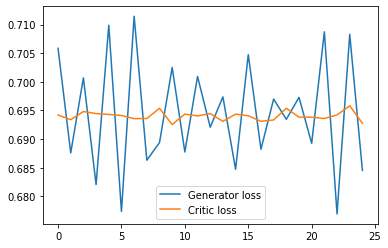

step 8500: Generator loss: 0.6947547912597656, discriminator loss: 0.6938212288618087


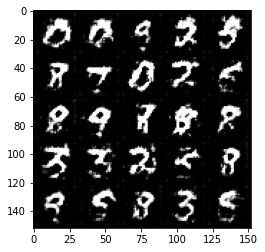

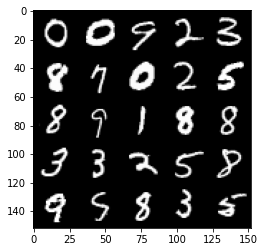

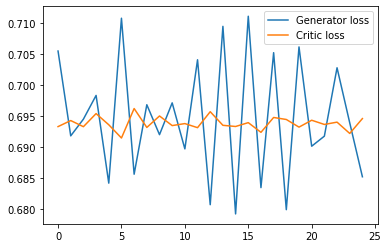

step 9000: Generator loss: 0.6942887327671051, discriminator loss: 0.6937729170322419


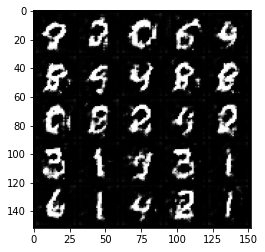

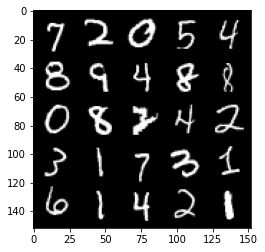

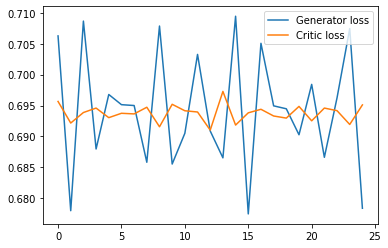

step 9500: Generator loss: 0.6945942722558975, discriminator loss: 0.6936584560871124


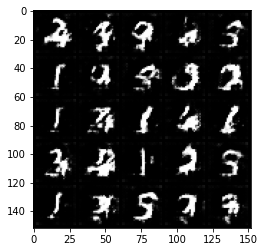

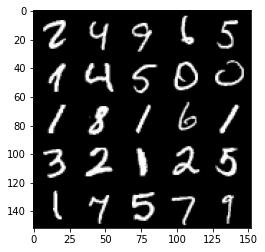

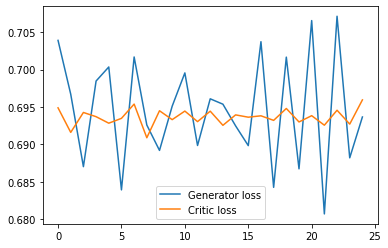

step 10000: Generator loss: 0.6940360087156295, discriminator loss: 0.6935183612108231


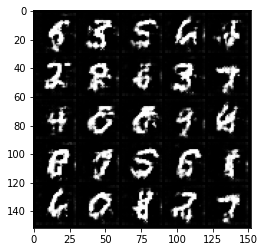

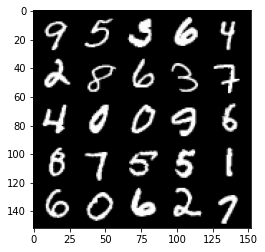

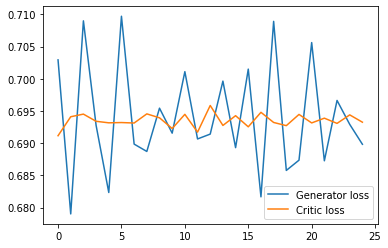

step 10500: Generator loss: 0.6939387747049331, discriminator loss: 0.693475014090538


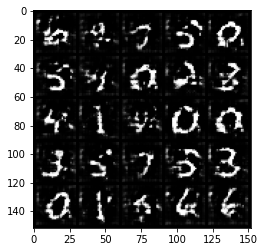

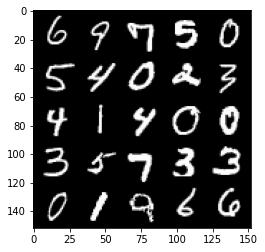

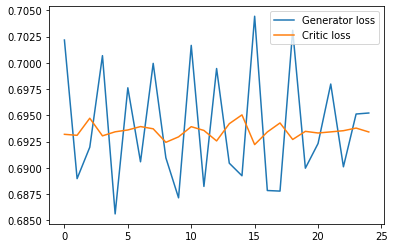

step 11000: Generator loss: 0.6935532515048981, discriminator loss: 0.6933792150020599


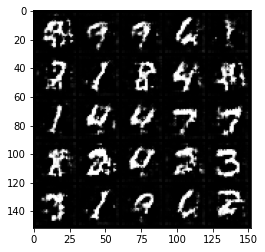

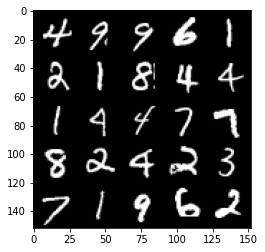

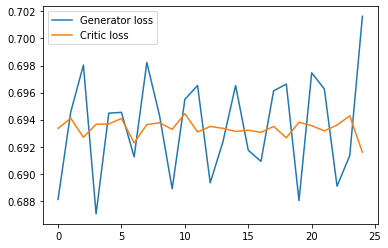

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []
n_classes = 10

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # upgrade discriminator
        one_hot_labels = get_one_Hot_labels(labels.to(device), n_classes)

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels) # (G(z|y))
        real_image_and_labels = combine_vectors(real, image_one_hot_labels) # x|y

        disc_fake_pred = disc(fake_image_and_labels.detach()) # D(G(z|y))
        disc_real_pred = disc(real_image_and_labels) # D(x|y)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss)/2
        
        # track the average disc loss
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]
        
        # update generator
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # track the average gen loss
        generator_losses += [gen_loss.item()]

#         if test_generator:
#             try:
#                 assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch ==0)
#                 assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
#             except:
#                 error=True
#                 print("Runtime tests have failed")

        # visualize the results
    
        if cur_step % display_step == 0 and cur_step >0:
          gen_mean = sum(generator_losses[-display_step:]) / display_step
          disc_mean = sum(discriminator_losses[-display_step:]) / display_step
          print(f"step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
          show_tensor_images(fake)
          show_tensor_images(real)
          step_bins = 20
          num_examples = (len(generator_losses) // step_bins) * step_bins
          plt.plot (
              range(num_examples // step_bins), 
              torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
              label="Generator loss"
          )
          plt.plot (
              range(num_examples // step_bins), 
              torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
              label="Critic loss"
          )
          plt.legend()
          plt.show()
          generator_losses = []
          discriminator_losses = []
        cur_step += 1
                                  